In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.t8btag_minmass
dout = "ranked_quadh"

In [4]:
altfile = 'ranked_quadh_{base}'
use_signal = [ module.full_signal_list.index(f) for f in module.signal_list ]
signal = ObjIter([Tree(f, altfile=altfile) for f in module.full_signal_list])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])
data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile=altfile) ])


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


In [5]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [6]:
ptcut = eightb.selected_jet_pt()

btagcut = eightb.selected_jet_btagwp()

event_filter = FilterSequence(
    ptcut, btagcut
)

signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

In [7]:
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221115_ranger_lr0.0047_batch512_m7m10m12/"


In [8]:
cutflow_labels = [
    "total", "trigger","met filters", "muon veto", "electron veto", "n_presel_jets >= 8", "selected_jets", "selected_jets_pt", "selected_jets_btag"
]

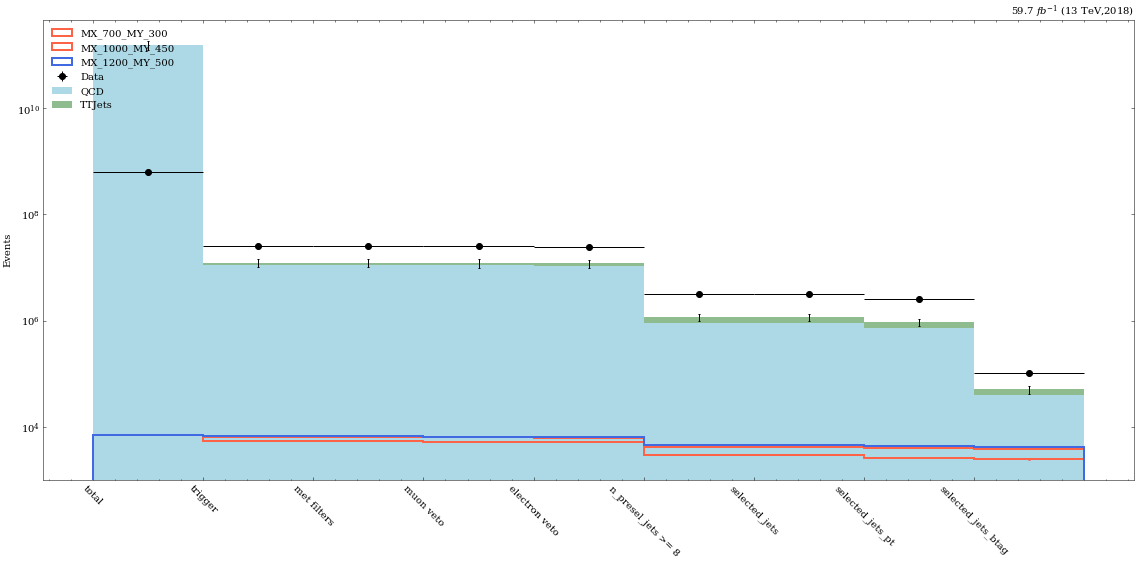

In [9]:
study.cutflow( 
    signal[use_signal] + bkg + data,
    ylim=(1e3, -1),
    xlabel=cutflow_labels,
    legend=True,
)

In [10]:
features = [
        'jet_ht','min_jet_deta','max_jet_deta','min_jet_dr','max_jet_dr'
    ] + [
        f'h{i+1}_{var}'
        for var in ('pt','dr')
        for i in range(4)
    ] + [
        f'h{i+1}{j+1}_{var}'
        for var in ('dphi','deta')
        for i in range(4)
        for j in range(i+1, 4)
    ]

100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


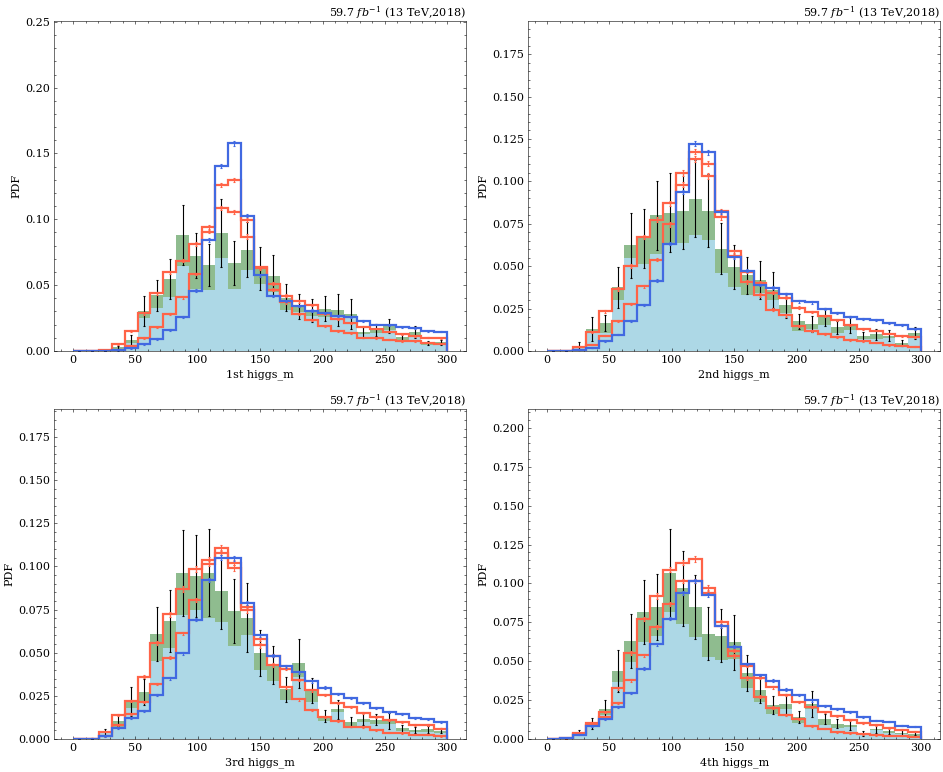

In [108]:
study.quick( 
    signal[use_signal]+bkg,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    efficiency=True,
)

In [109]:
def jet_relht(t):
    if 'jet_relht' not in t.fields:
        jet_ht = ak.sum(t.jet_pt, axis=-1)
        X_et  = np.sqrt( t.X_m**2 + t.X_pt**2 )
        jet_relht = jet_ht/X_et 
        t.extend(jet_relht=jet_relht)
    return t.jet_relht

100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


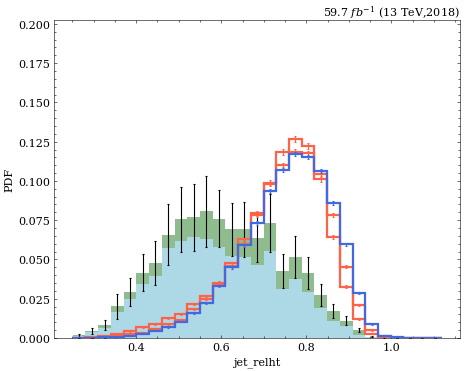

In [110]:
study.quick( 
    signal[use_signal]+bkg,
    varlist=[jet_relht],
    efficiency=True,
)

100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


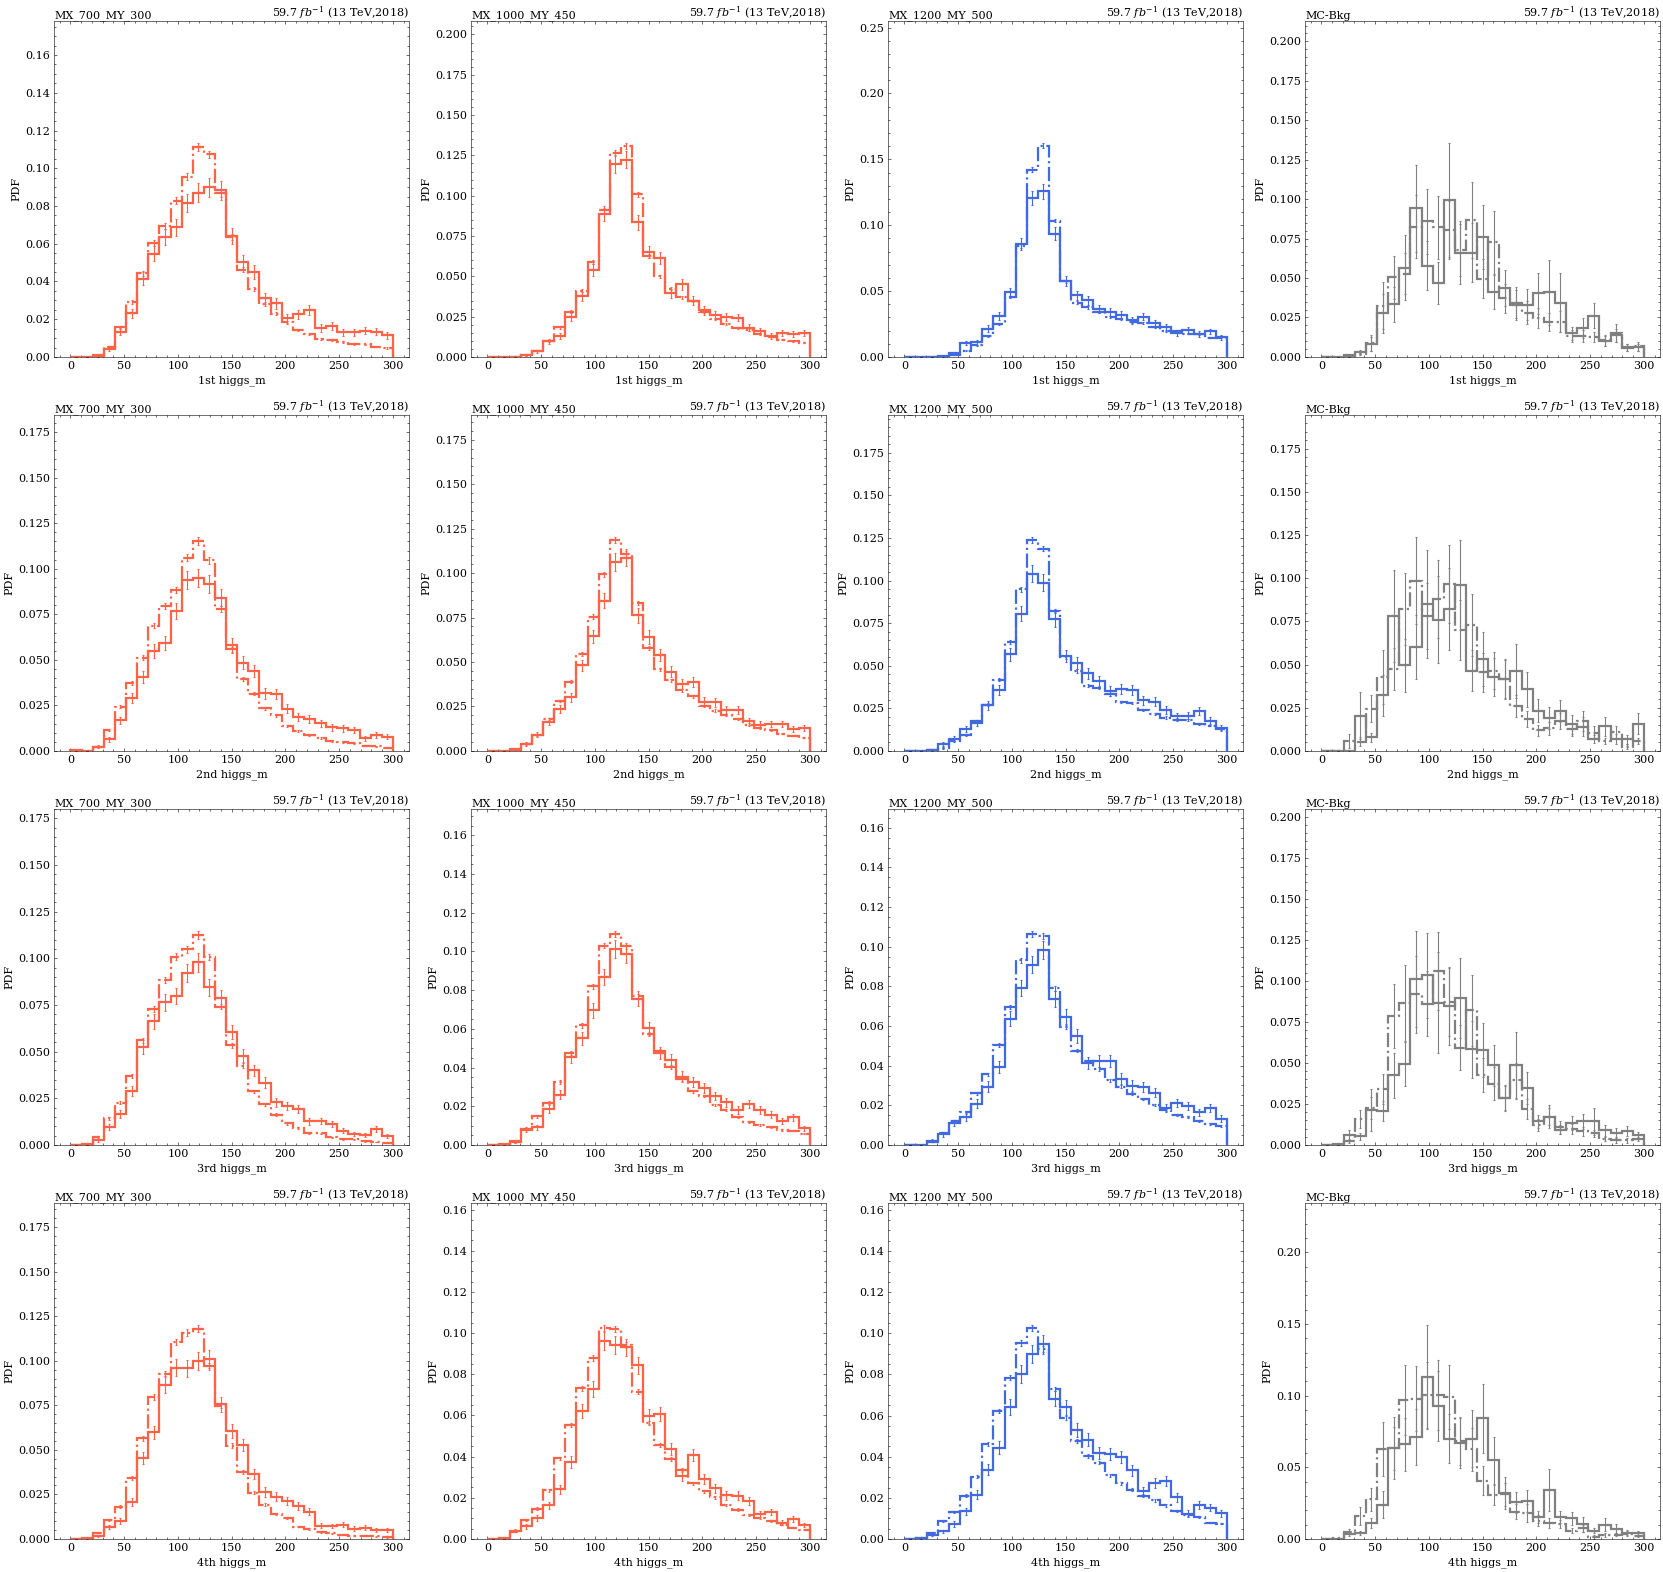

In [113]:
study.compare_masks( 
    signal[use_signal],bkg,
    masks=[lambda t : t.jet_relht < 0.6,lambda t : t.jet_relht > 0.6],
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    efficiency=True,
)

100%|██████████| 1/1 [00:08<00:00,  8.33s/it]


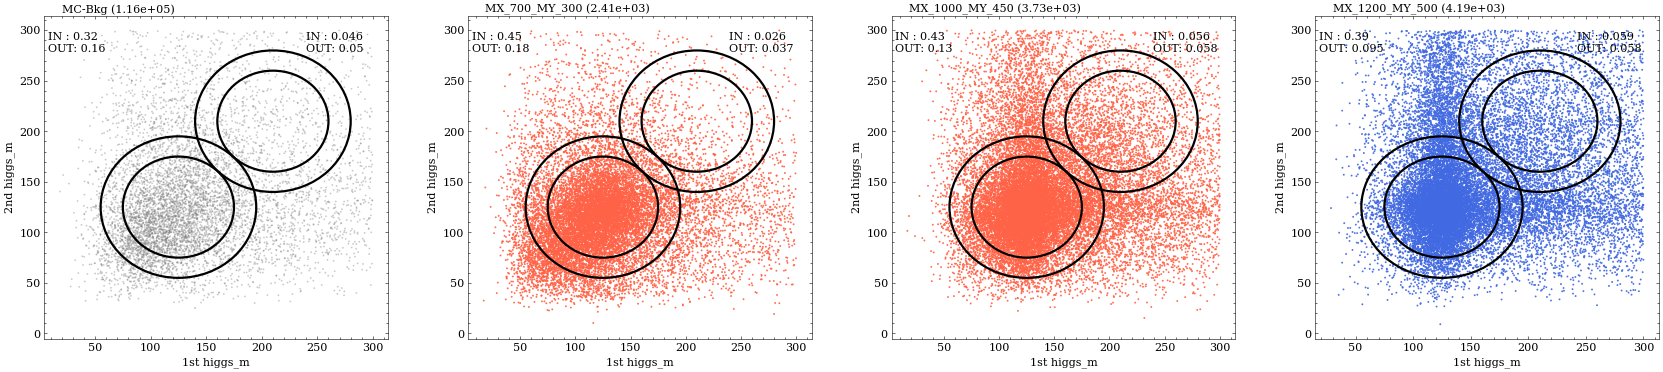

In [16]:
ar_center = [125,125]
vr_center = [210,210]
sr_r, cr_r =  50, 70

study.quick2d(
    signal[use_signal]+bkg,
    varlist=['higgs_m[:,0]','higgs_m[:,1]'],
    exe=[
        draw_concentric(*ar_center[:2], sr_r, cr_r, linewidth=2),
        draw_concentric(*vr_center[:2], sr_r, cr_r, text=(0.75,0.95), linewidth=2),
    ],
    scatter=True,
    saveas=f'{dout}/2d_higgs_space'
)

In [17]:
def higgs_dm(t, r = ar_center):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(higgs_dm = dm)
(signal+bkg+data).apply(higgs_dm)

def val_higgs_dm(t, r =  vr_center):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(val_higgs_dm = dm)
(signal+bkg+data).apply(val_higgs_dm)

[None, None, None, None, None, None, None, None, None, None, None]

In [18]:
ar_bdt = ABCD(
    features=features,
    a = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm < sr_r),
    b = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm < sr_r),
    c = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm > sr_r) & (t.higgs_dm < cr_r),
    d = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm > sr_r) & (t.higgs_dm < cr_r),
)

In [19]:
blind_filter = EventFilter('blinded', filter=lambda t : ~( ar_bdt.a(t) ))
blinded_data  = data.apply(blind_filter)

In [20]:
# study.quick( 
#     blinded_data + bkg,
#     legend=True,
#     masks=ar_bdt.cr,
#     varlist=ar_bdt.feature_names,
#     ratio=True, r_ylabel='Data/MC'
# )

In [21]:
bkg_model = blinded_data.asmodel('bkg model')

In [22]:
ar_bdt.train(bkg_model)
ar_bdt.print_results(bkg_model)

... fetching features
... splitting features
... calculating k factor
... fitting reweighter
--- ABCD Results ---
k = 2.983e-01
k*(b/a)-1  = inf%
BDT(b)/a-1 = inf%



100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


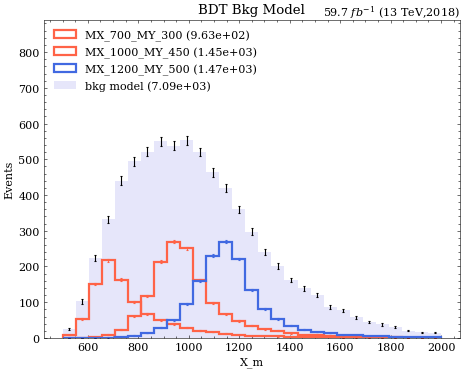

In [23]:
study.quick(
    signal[use_signal] + bkg_model, 
    legend=True,
    masks=[ar_bdt.a]*len(use_signal)+[ar_bdt.b]*len(bkg_model),
    scale=[1]*len(use_signal)+[ar_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'],
    binlist=[(500,2000,30)],
    title='BDT Bkg Model',
    # limits=True,
    # saveas=f'{dout}/limits/bdt_bkg_model'
)

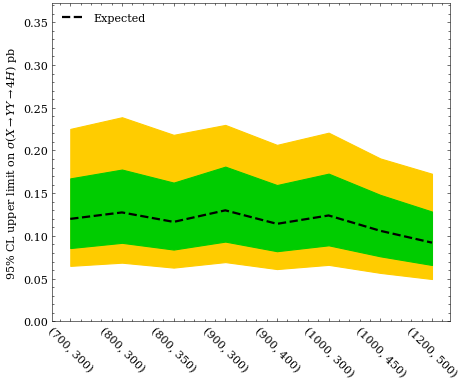

In [25]:
fig, ax = study.get_figax()

study.brazil( 
    signal + bkg_model,
    masks=[ar_bdt.a]*len(signal)+[ar_bdt.b]*len(bkg_model),
    scale=[1]*len(signal)+[ar_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'], 
    binlist=[(500,2000,15)],
    # use_norm=True,
    ylim=(0,0.31),
    l_poi=np.linspace(0,3,21), 
    figax=(fig,ax)
    # l_saveas='~/nobackup/tmp/debug_limits_{h_sig.label}.root'
)

In [20]:
vr_bdt = ABCD(
    features=features,
    a = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm < sr_r),
    b = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm < sr_r),
    c = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm > sr_r) & (t.val_higgs_dm < cr_r),
    d = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm > sr_r) & (t.val_higgs_dm < cr_r),
)

In [21]:
vr_bdt.train(bkg_model)
vr_bdt.print_results(bkg_model)

... fetching features
... splitting features
... calculating k factor
... fitting reweighter
--- ABCD Results ---
k = 3.010e-01
k*(b/a)-1  = 0.95%
BDT(b)/a-1 = 0.95%



In [22]:
# bkg_model.apply(vr_bdt.get_features)

In [23]:
# bkg_model.apply(vr_bdt.reweight_tree)

100%|██████████| 25/25 [01:36<00:00,  3.85s/it]


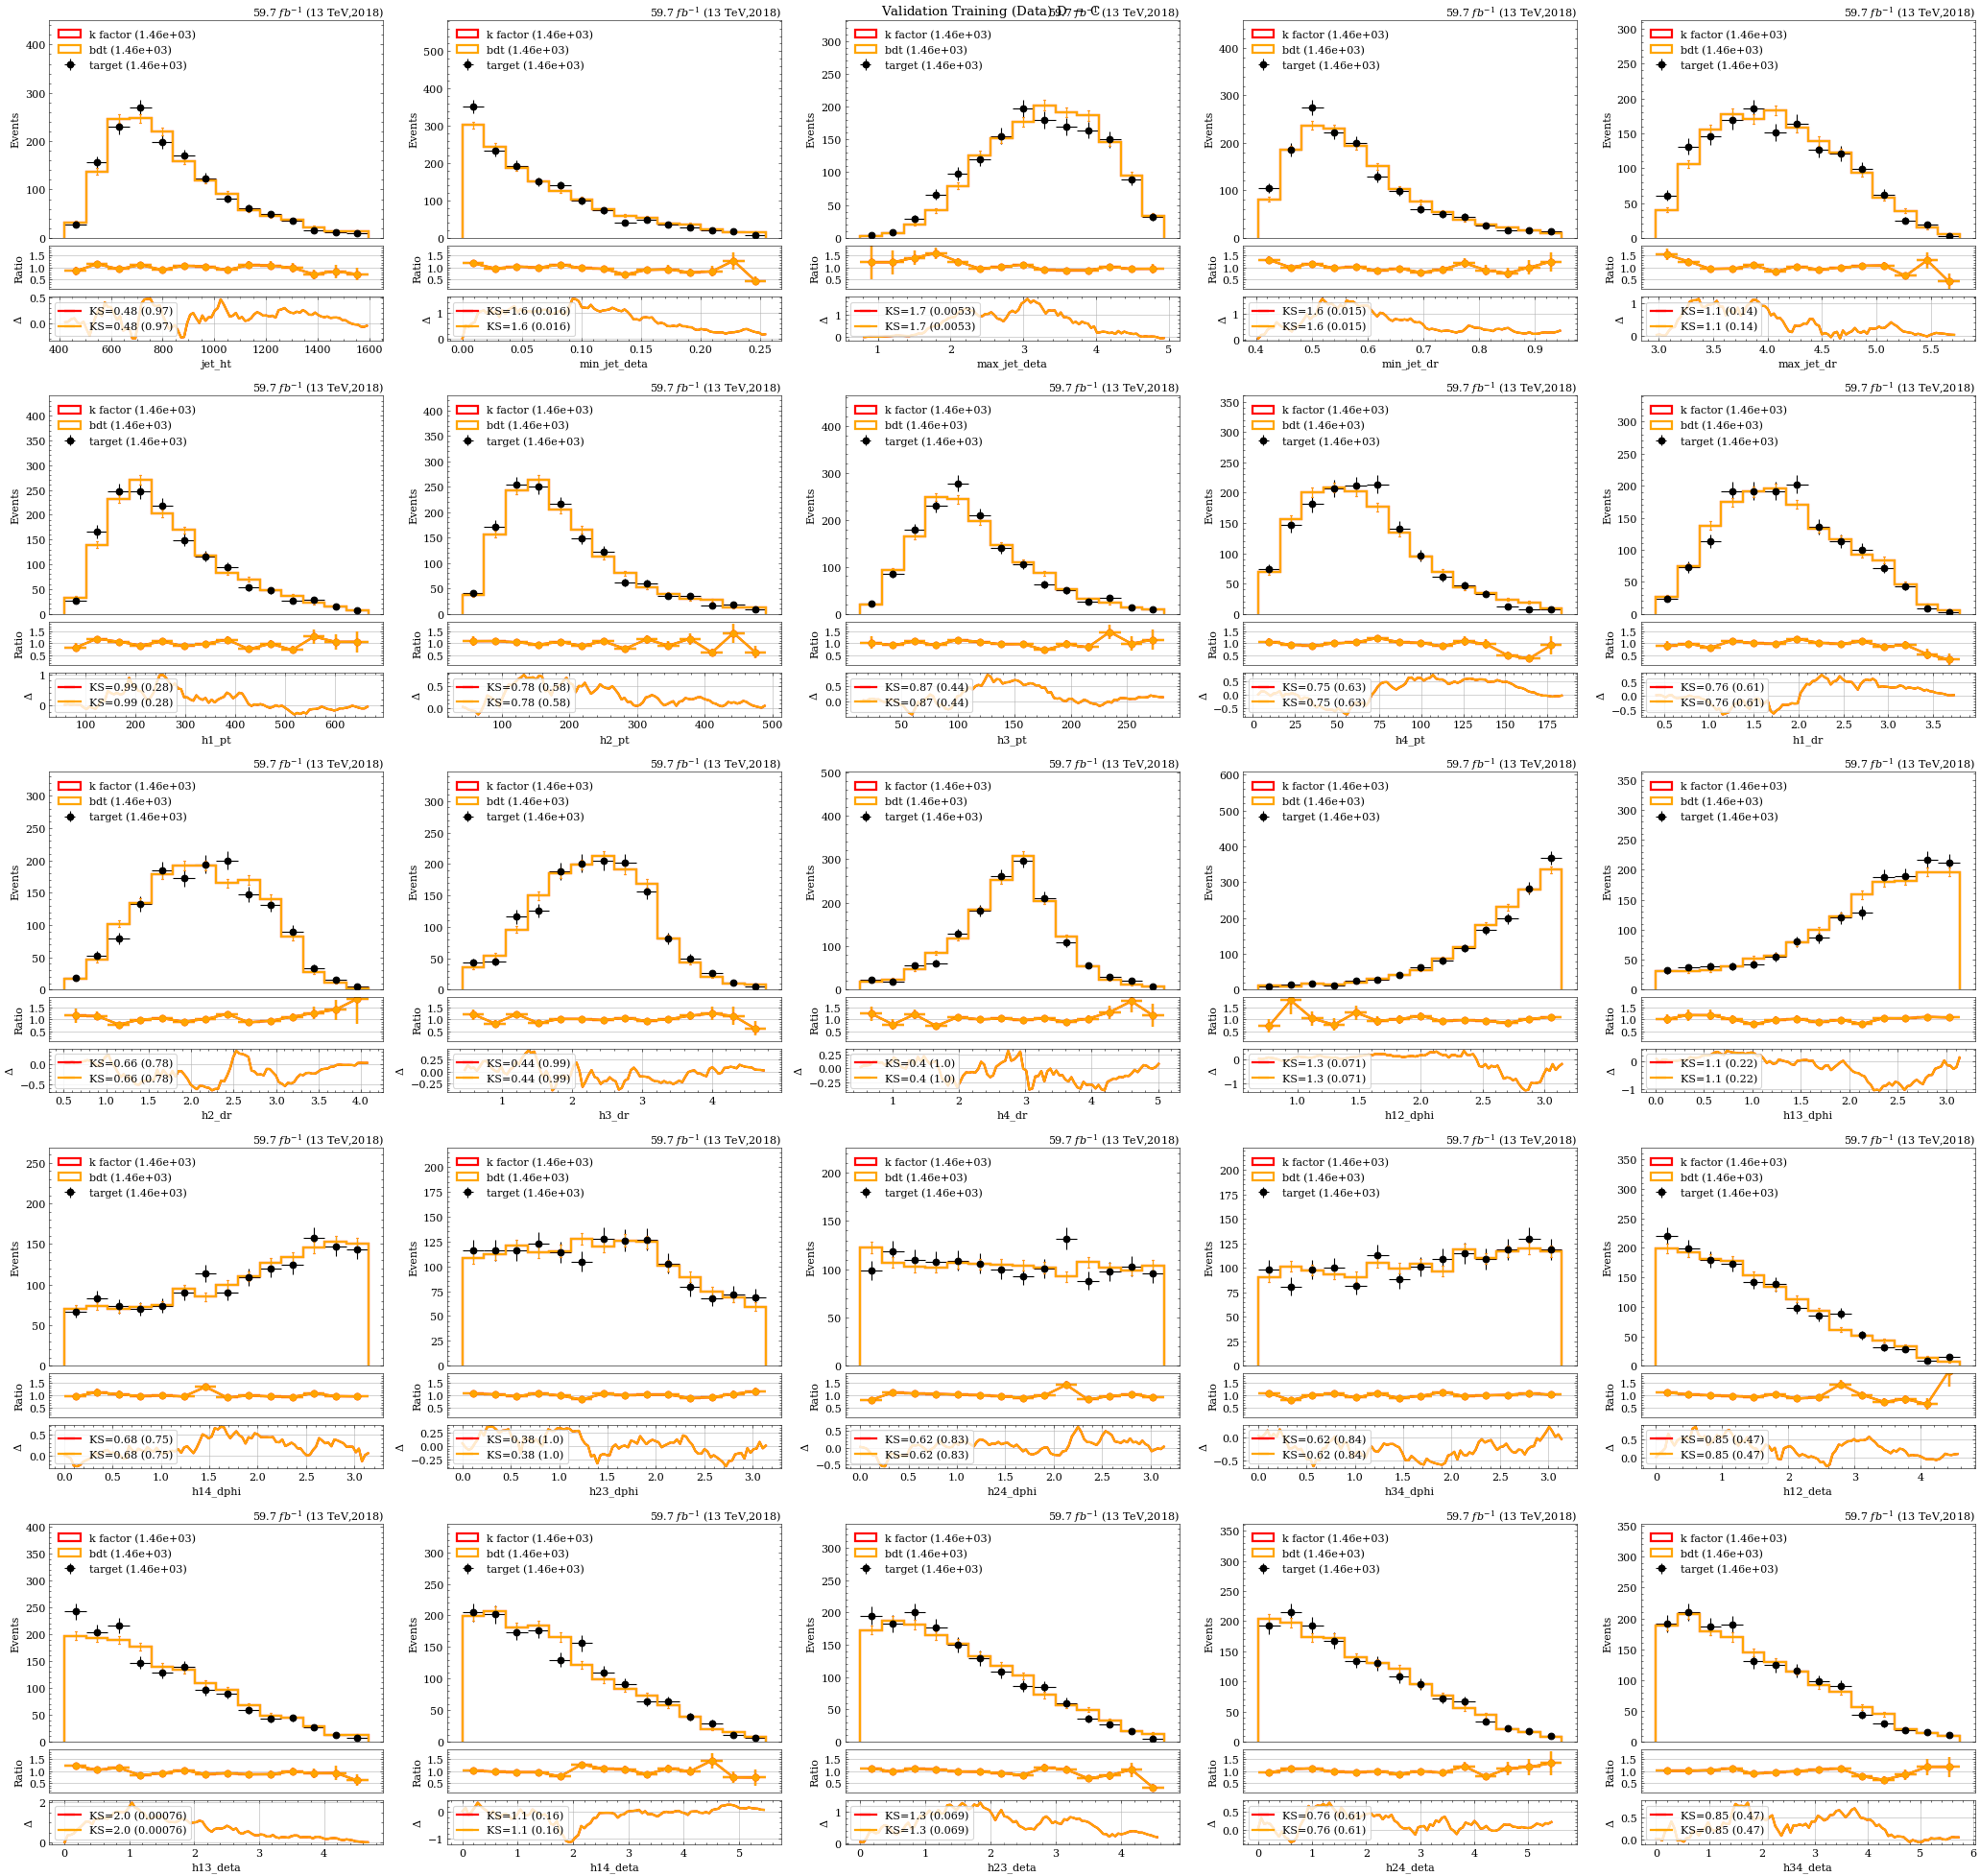

In [29]:
study.quick_region(
    blinded_data , bkg_model, bkg_model, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[vr_bdt.c]*len(data)+[vr_bdt.d]*(len(bkg_model)*2),
    scale=[1]*len(data)+[vr_bdt.scale_tree]*len(bkg_model)+[vr_bdt.reweight_tree]*len(bkg_model),
    varlist=vr_bdt.feature_names,
    h_rebin=15,
    suptitle='Validation Training (Data) D $\\rightarrow$ C',
    ratio=True,
    **study.kstest,
    saveas=f'{dout}/vr_bdt/training'
)

100%|██████████| 25/25 [01:30<00:00,  3.64s/it]


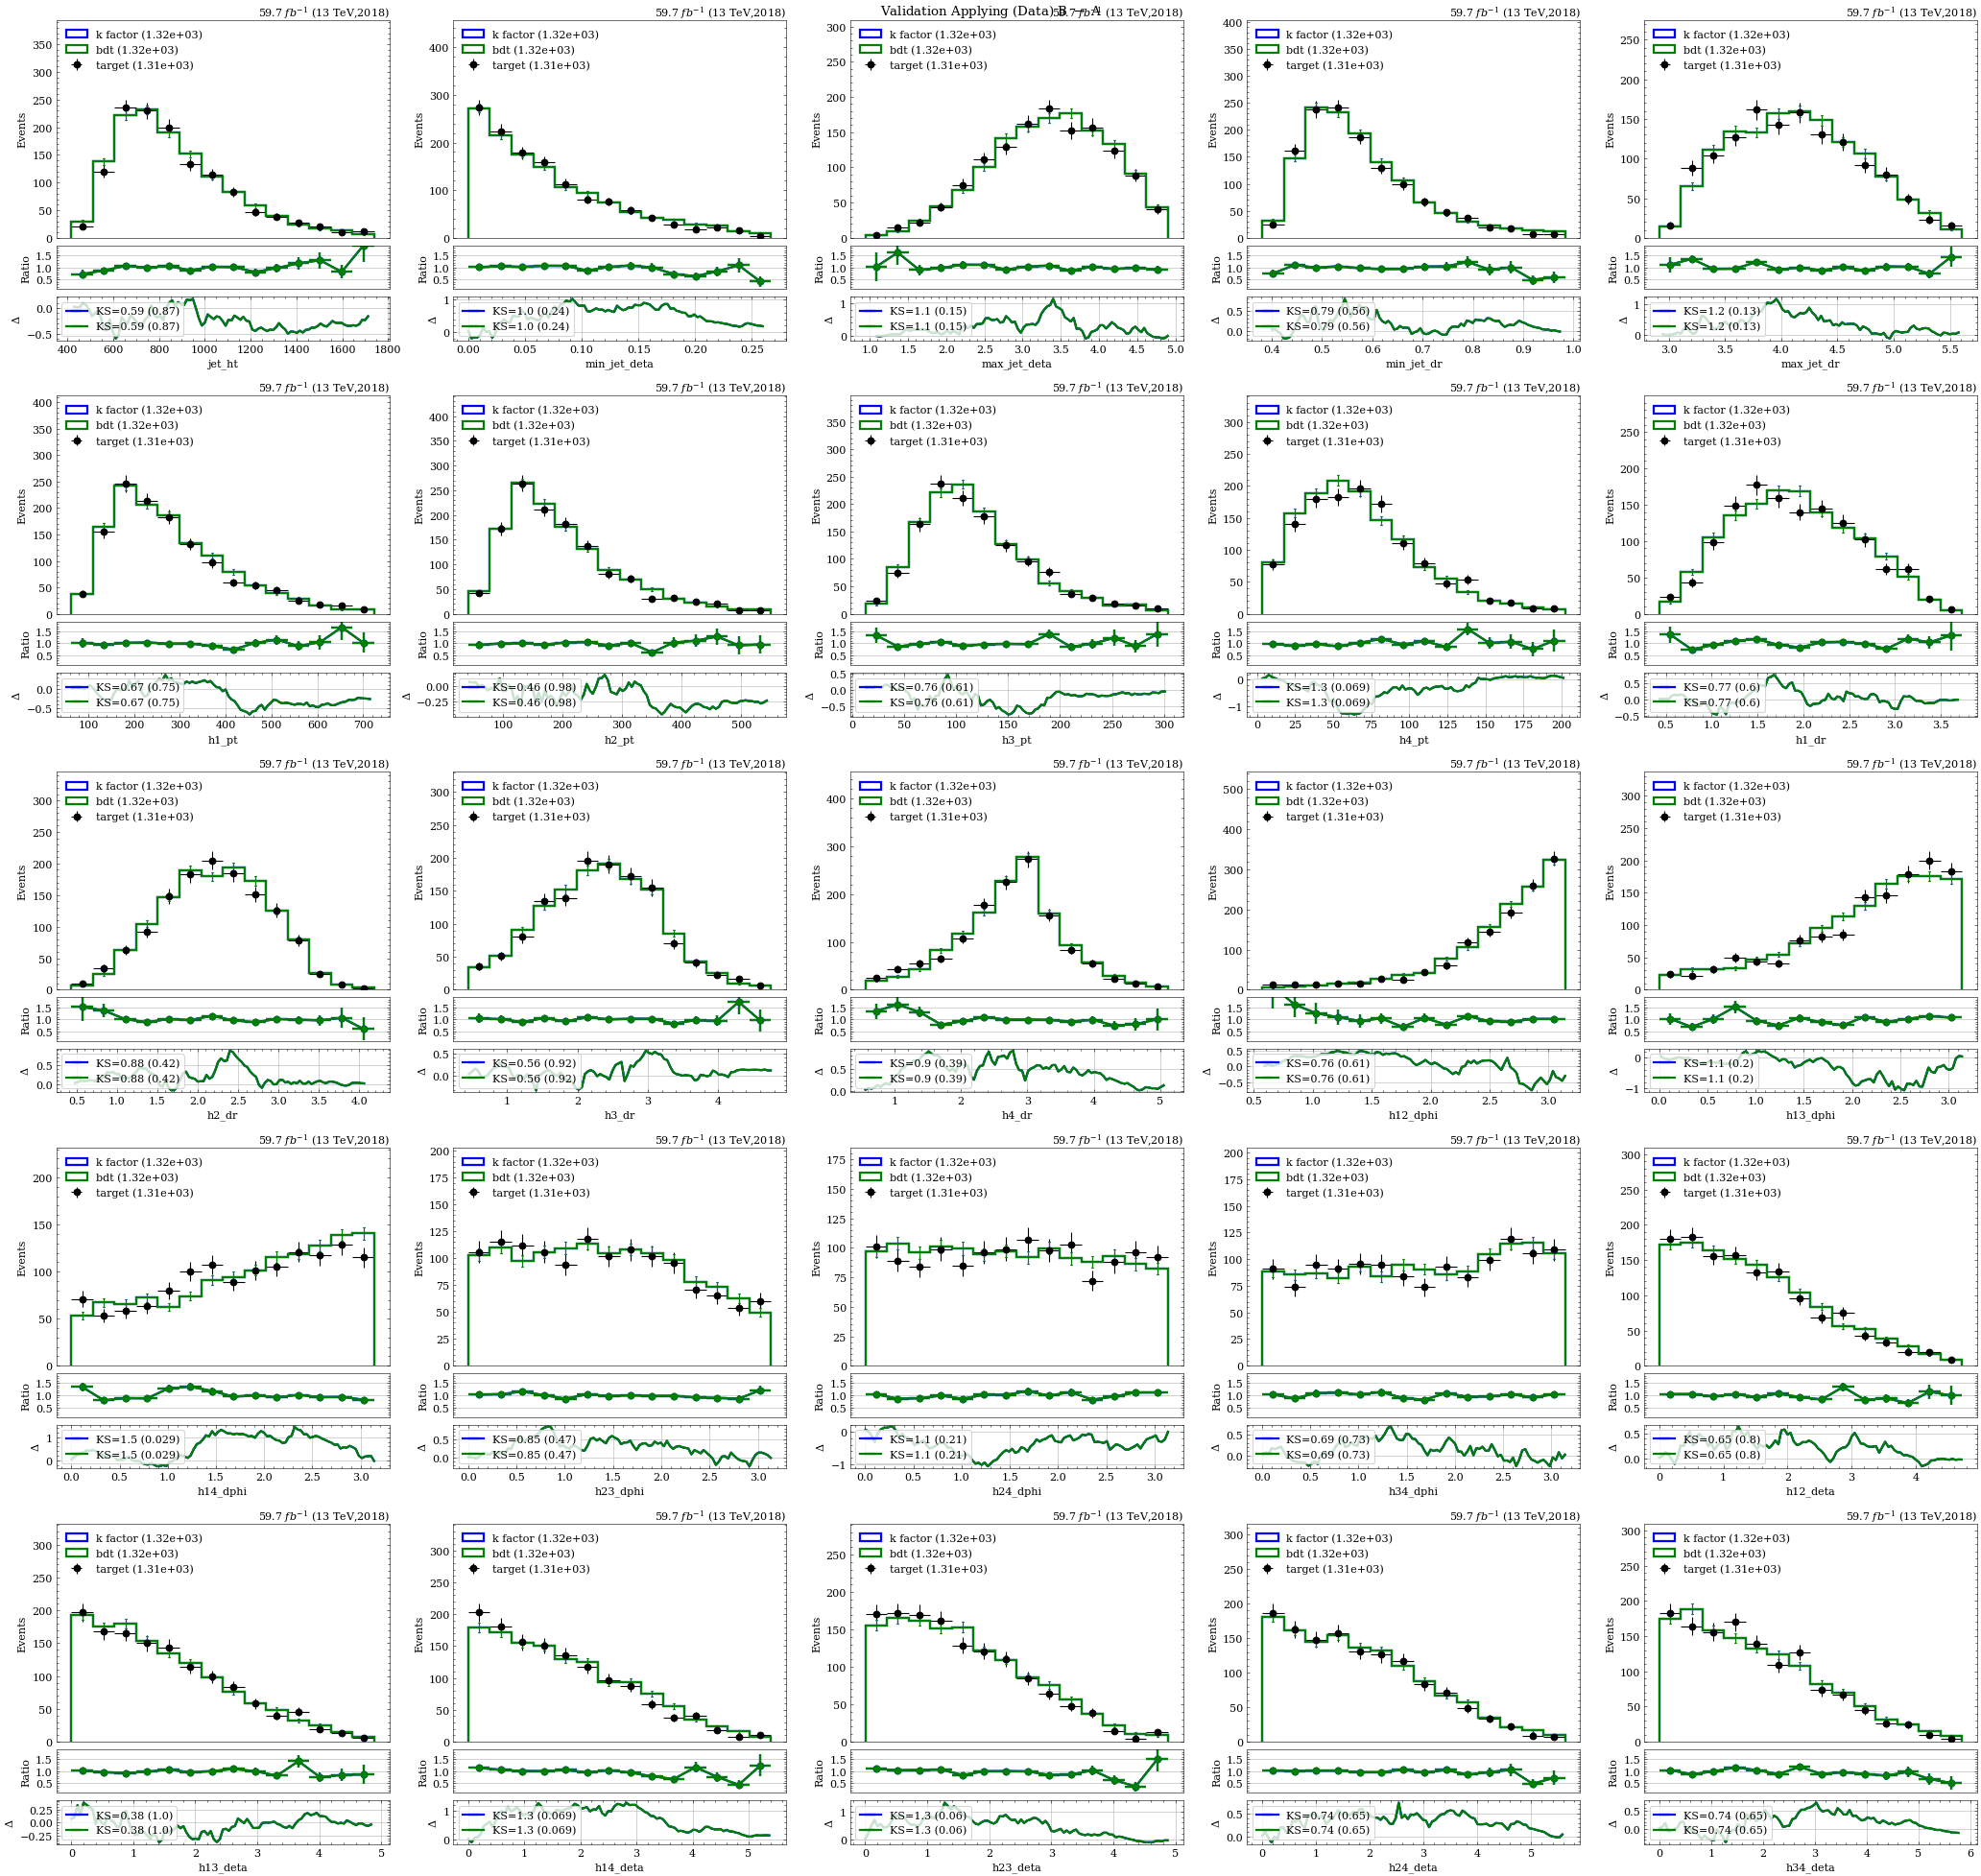

In [30]:
study.quick_region(
    blinded_data , bkg_model, bkg_model, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[vr_bdt.a]*len(data)+[vr_bdt.b]*(len(bkg_model)*2),
    scale=[1]*len(data)+[vr_bdt.scale_tree]*len(bkg_model)+[vr_bdt.reweight_tree]*len(bkg_model),
    varlist=vr_bdt.feature_names,
    h_rebin=15,
    suptitle='Validation Applying (Data) B $\\rightarrow$ A',
    ratio=True,
    **study.kstest,
    saveas=f'{dout}/vr_bdt/applying',
)